# My bounding box implementation

**Steps:**
1. Prepare the data and visualization [DONE]
    1. Create image lists with annotations, bbs [DONE]
    2. Create plotting functions [DONE]
2. Largest object classifier
    1. Get the largest item and save appropriate CSV file
    2. Train a pretrained classifier
    3. Check out how well it does
3. Bounding box only regression problem
    1. Prepare the data and save as CSV file
    2. Train a pretrained classifier
    3. Check out how well it does
4. Combine the two for a single object detector

In [1]:
%load_ext autoreload
%autoreload 2

In [121]:
%matplotlib inline
from fastai.imports import *
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.transforms import *
from matplotlib import patches, patheffects

## Prepare the data

Use pathlib!

In [3]:
PATH = Path('data/pascal/')

In [4]:
list(PATH.iterdir())

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/VOC2012')]

In [5]:
!ls {PATH}/VOC2007/

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


### Create image lists with annotations and bbs

One list with all images, another list of lists of annotations for all the images.

In [6]:
# Load the 2007 train json file
train_json = json.load((PATH/'pascal_train2007.json').open())

In [7]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [9]:
cats = {d['id']: d['name'] for d in train_json['categories']}; print(cats)

{1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


In [10]:
IMAGES, ANNOTATIONS, IMAGE_ID, BBOX = 'images', 'annotations', 'image_id', 'bbox'

In [11]:
train_json[IMAGES][:3], len(train_json[IMAGES])

([{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
  {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
  {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}],
 2501)

In [12]:
train_json['annotations'][:2], len(train_json['annotations'])

([{'area': 34104,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0,
   'image_id': 12,
   'iscrowd': 0,
   'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
  {'area': 13110,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0,
   'image_id': 17,
   'iscrowd': 0,
   'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}],
 7844)

In [35]:
# Is there an annotation for each image?
anno_imgs = [d[IMAGE_ID] for d in train_json[ANNOTATIONS] if not d['ignore']]

In [36]:
len(set(anno_imgs)) # Yes

2501

In [17]:
# Are there any ignores?
sum([d['ignore'] for d in train_json[ANNOTATIONS]]) # Yes

1543

In [21]:
train_fns = {d['id']: d['file_name'] for d in train_json[IMAGES]}

In [22]:
# Change rows and columns
# orig annos are col/row/width/height
# convert to upper left row/col bottomright row/col
cov2np = lambda a: [a[1], a[0], a[1]+a[3], a[0]+a[2]]
np2cov = lambda a: [a[1], a[0], a[3]-a[1], a[2]-a[0]]

In [23]:
train_annos = collections.defaultdict(lambda: [])
for d in train_json[ANNOTATIONS]:
    if not d['ignore']:
        train_annos[d[IMAGE_ID]].append([cov2np(d['bbox']), d['category_id']])

In [24]:
# I also want a dict mapping continuous integers to the image ids
cont_idxs = {i : d['id'] for i,d in enumerate(train_json[IMAGES])}

In [28]:
idx = 1
train_fns[cont_idxs[idx]], train_annos[cont_idxs[idx]]

('000017.jpg', [[[61, 184, 199, 279], 15], [[77, 89, 336, 403], 13]])

### Plotting functions

In [29]:
def show_img(im):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(im)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    return ax

In [30]:
IMG_PATH = PATH/'VOC2007/JPEGImages'

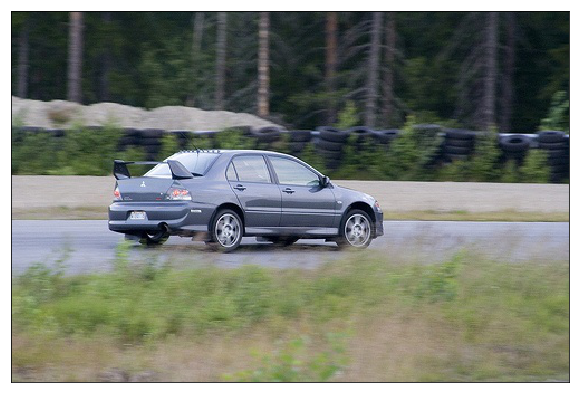

In [34]:
ax = show_img(Image.open(IMG_PATH/train_fns[cont_idxs[3]]))

In [37]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [38]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [39]:
def draw_text(ax, xy, txt):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=16, weight='bold')
    draw_outline(text, 1)

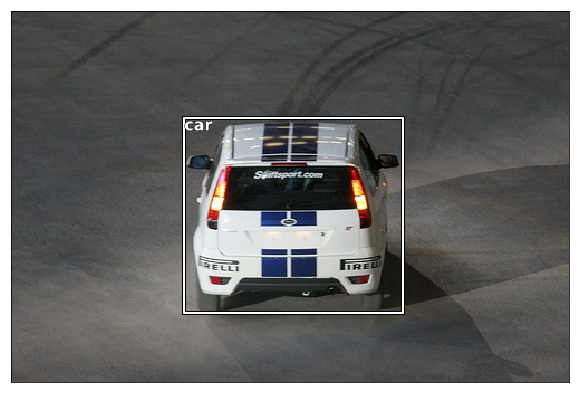

In [41]:
idx = cont_idxs[0]
ax = show_img(Image.open(IMG_PATH/train_fns[idx]))
bb_cov = np2cov(train_annos[idx][0][0])
draw_rect(ax, bb_cov)
draw_text(ax, bb_cov[:2], cats[train_annos[12][0][1]])

In [42]:
def plot_img_ann(im, ann):
    ax = show_img(im)
    for bb, cat in ann:
        bb_cov = np2cov(bb)
        draw_rect(ax, bb_cov)
        draw_text(ax, bb_cov[:2], cats[cat])

In [46]:
def plot_idx(idx):
    idx = cont_idxs[idx]
    im = open_image(IMG_PATH/train_fns[idx])
    ann = train_annos[idx]
    plot_img_ann(im , ann)

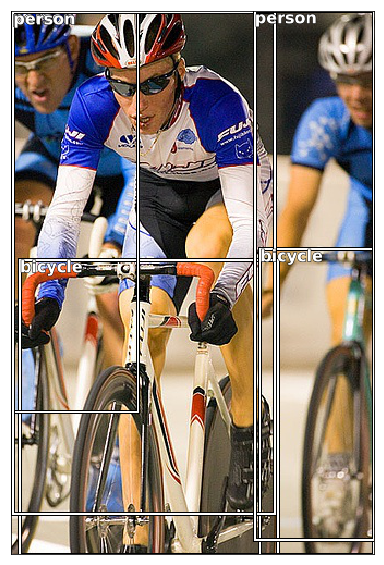

In [99]:
plot_idx(2)

## Largest item detector

### Prepare the dataset

In [51]:
train_annos.items()

dict_items([(12, [[[96, 155, 270, 351], 7]]), (17, [[[61, 184, 199, 279], 15], [[77, 89, 336, 403], 13]]), (23, [[[229, 8, 500, 245], 2], [[219, 229, 500, 334], 2], [[0, 1, 369, 117], 15], [[1, 2, 462, 243], 15], [[0, 224, 486, 334], 15]]), (26, [[[124, 89, 212, 337], 7]]), (32, [[[77, 103, 183, 375], 1], [[87, 132, 123, 197], 1], [[179, 194, 229, 213], 15], [[188, 25, 238, 44], 15]]), (33, [[[106, 8, 263, 499], 1], [[199, 420, 226, 482], 1], [[187, 324, 223, 411], 1]]), (34, [[[166, 115, 400, 360], 19], [[152, 140, 229, 333], 19]]), (35, [[[95, 0, 361, 191], 15], [[97, 217, 318, 465], 15]]), (36, [[[78, 26, 344, 319], 12]]), (42, [[[31, 262, 295, 500], 19], [[35, 0, 299, 235], 19]]), (44, [[[0, 0, 330, 370], 9], [[100, 98, 213, 312], 8]]), (47, [[[0, 14, 312, 459], 7], [[169, 438, 230, 487], 9]]), (48, [[[106, 57, 465, 291], 3], [[0, 1, 500, 302], 15]]), (61, [[[10, 273, 279, 437], 4], [[213, 183, 252, 281], 4]]), (64, [[[22, 0, 500, 451], 3]]), (66, [[[186, 208, 230, 228], 15], [[181

In [56]:
cont_idxs[4]

32

In [59]:
l = train_annos[32][0]; l

[[77, 103, 183, 375], 1]

In [62]:
l[0][2]

183

In [63]:
(l[0][2]-l[0][0]) *(l[0][3]-l[0][1])

28832

In [101]:
sorted(train_annos[cont_idxs[2]], key=lambda l: (l[0][2]-l[0][0]) *(l[0][3]-l[0][1]))

[[[219, 229, 500, 334], 2],
 [[0, 1, 369, 117], 15],
 [[0, 224, 486, 334], 15],
 [[229, 8, 500, 245], 2],
 [[1, 2, 462, 243], 15]]

In [103]:
[(l[0][2]-l[0][0]) *(l[0][3]-l[0][1]) for l in train_annos[cont_idxs[2]]]

[64227, 29505, 42804, 111101, 53460]

In [106]:
(462-1) *(243-2)

111101

In [107]:
(500-229) *(245-8)

64227

In [102]:
cats[2]

'bicycle'

In [108]:
# I want to return a dictionary which has key image id and value [bb, cat] for largest item
train_annos_lrg = collections.defaultdict()
for idx, bblist in train_annos.items():
    train_annos_lrg[idx] = sorted(bblist, key=lambda l: (l[0][2]-l[0][0]) *(l[0][3]-l[0][1]), reverse=True)[0]

In [109]:
train_annos_lrg

defaultdict(None,
            {12: [[96, 155, 270, 351], 7],
             17: [[77, 89, 336, 403], 13],
             23: [[1, 2, 462, 243], 15],
             26: [[124, 89, 212, 337], 7],
             32: [[77, 103, 183, 375], 1],
             33: [[106, 8, 263, 499], 1],
             34: [[166, 115, 400, 360], 19],
             35: [[97, 217, 318, 465], 15],
             36: [[78, 26, 344, 319], 12],
             42: [[31, 262, 295, 500], 19],
             44: [[0, 0, 330, 370], 9],
             47: [[0, 14, 312, 459], 7],
             48: [[0, 1, 500, 302], 15],
             61: [[10, 273, 279, 437], 4],
             64: [[22, 0, 500, 451], 3],
             66: [[181, 241, 259, 274], 15],
             73: [[142, 120, 460, 375], 16],
             77: [[0, 1, 333, 306], 8],
             78: [[74, 14, 412, 475], 12],
             83: [[32, 108, 309, 447], 7],
             89: [[50, 21, 291, 317], 9],
             91: [[240, 124, 284, 195], 7],
             104: [[6, 1, 333, 283], 15],
 

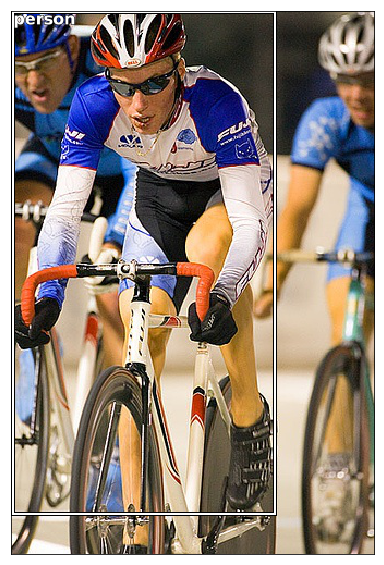

In [110]:
idx = cont_idxs[2]
im = open_image(IMG_PATH/train_fns[idx])
ann = train_annos_lrg[idx]
plot_img_ann(im , [ann])

In [111]:
# Convert it to whatever fastai from csv wants to see.
# For now we want just the category
train_cat_lrg = {i: v[1] for i,v in train_annos_lrg.items()}

In [112]:
[train_fns[cont_idxs[i]] for i in range(len(cont_idxs))]

['000012.jpg',
 '000017.jpg',
 '000023.jpg',
 '000026.jpg',
 '000032.jpg',
 '000033.jpg',
 '000034.jpg',
 '000035.jpg',
 '000036.jpg',
 '000042.jpg',
 '000044.jpg',
 '000047.jpg',
 '000048.jpg',
 '000061.jpg',
 '000064.jpg',
 '000066.jpg',
 '000073.jpg',
 '000077.jpg',
 '000078.jpg',
 '000083.jpg',
 '000089.jpg',
 '000091.jpg',
 '000104.jpg',
 '000112.jpg',
 '000122.jpg',
 '000129.jpg',
 '000133.jpg',
 '000134.jpg',
 '000138.jpg',
 '000140.jpg',
 '000141.jpg',
 '000147.jpg',
 '000153.jpg',
 '000154.jpg',
 '000159.jpg',
 '000161.jpg',
 '000162.jpg',
 '000163.jpg',
 '000164.jpg',
 '000171.jpg',
 '000173.jpg',
 '000174.jpg',
 '000187.jpg',
 '000189.jpg',
 '000192.jpg',
 '000193.jpg',
 '000194.jpg',
 '000198.jpg',
 '000200.jpg',
 '000207.jpg',
 '000209.jpg',
 '000219.jpg',
 '000220.jpg',
 '000222.jpg',
 '000225.jpg',
 '000228.jpg',
 '000235.jpg',
 '000242.jpg',
 '000250.jpg',
 '000256.jpg',
 '000259.jpg',
 '000262.jpg',
 '000263.jpg',
 '000276.jpg',
 '000278.jpg',
 '000282.jpg',
 '000288.j

In [113]:
[train_cat_lrg[cont_idxs[i]] for i in range(len(cont_idxs))]

[7,
 13,
 15,
 7,
 1,
 1,
 19,
 15,
 12,
 19,
 9,
 7,
 15,
 4,
 3,
 15,
 16,
 8,
 12,
 7,
 9,
 7,
 15,
 12,
 8,
 15,
 15,
 7,
 15,
 18,
 3,
 9,
 7,
 4,
 7,
 7,
 15,
 14,
 14,
 15,
 13,
 15,
 20,
 3,
 15,
 15,
 13,
 19,
 15,
 6,
 8,
 14,
 7,
 15,
 17,
 1,
 11,
 8,
 5,
 1,
 15,
 7,
 7,
 15,
 15,
 15,
 6,
 3,
 4,
 10,
 16,
 7,
 19,
 7,
 15,
 1,
 9,
 7,
 15,
 5,
 13,
 11,
 7,
 9,
 15,
 4,
 13,
 2,
 4,
 7,
 16,
 15,
 3,
 8,
 7,
 7,
 13,
 15,
 17,
 8,
 1,
 15,
 15,
 19,
 12,
 14,
 15,
 7,
 13,
 7,
 15,
 15,
 16,
 3,
 9,
 18,
 3,
 15,
 6,
 4,
 7,
 13,
 14,
 15,
 8,
 15,
 12,
 7,
 8,
 8,
 11,
 1,
 18,
 15,
 20,
 2,
 13,
 14,
 15,
 7,
 18,
 15,
 7,
 12,
 19,
 7,
 10,
 15,
 9,
 15,
 19,
 6,
 17,
 1,
 2,
 7,
 3,
 14,
 7,
 19,
 13,
 9,
 7,
 15,
 9,
 16,
 15,
 16,
 15,
 14,
 15,
 4,
 11,
 6,
 18,
 13,
 10,
 6,
 10,
 19,
 2,
 3,
 18,
 12,
 15,
 15,
 19,
 17,
 14,
 7,
 10,
 15,
 6,
 11,
 1,
 12,
 3,
 14,
 15,
 7,
 15,
 16,
 7,
 1,
 7,
 16,
 14,
 18,
 19,
 17,
 12,
 15,
 4,
 1,
 8,
 15,
 12,
 11,
 1,


In [156]:
# Save a csv file: first col = img fn. Second col cat
df = pd.DataFrame(
    {'fns': [train_fns[cont_idxs[i]] for i in range(len(cont_idxs))],
     'cat': [cats[train_cat_lrg[cont_idxs[i]]] for i in range(len(cont_idxs))]},
    columns=['fns', 'cat']
)

In [157]:
df.head()

,fns,cat
0,000012.jpg,car
1,000017.jpg,horse
2,000023.jpg,person
3,000026.jpg,car
4,000032.jpg,aeroplane


In [158]:
csv_path = './data/pascal/lrg_cat.csv'
df.to_csv(csv_path, index=False)

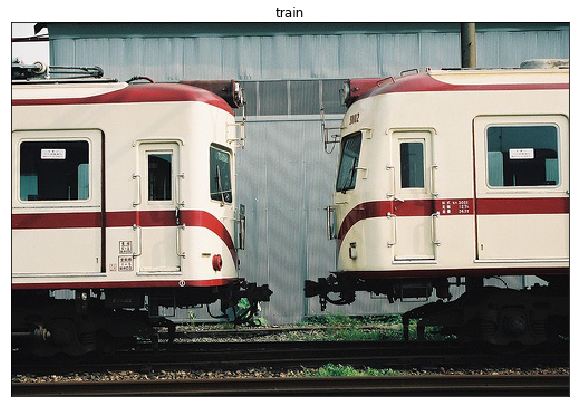

In [160]:
idx = 9
ax = show_img(Image.open(IMG_PATH/df['fns'][idx]))
ax.set_title(df['cat'][idx]);

### Train a pretrained classifier to detect largest category

In [161]:
f_model = resnet34
sz = 224
bs = 64

In [162]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)

In [163]:
data = ImageClassifierData.from_csv(PATH, 'VOC2007/JPEGImages/', csv_path, tfms=tfms)

In [164]:
x, y = next(iter(data.val_dl))

In [165]:
x.size(), y.size()

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [169]:
data.classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

person


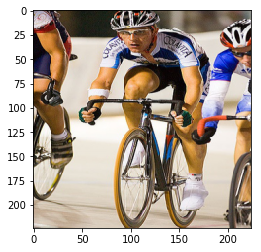

In [170]:
plt.imshow(data.val_ds.denorm(x.cpu().numpy())[0])
print(data.classes[y[0]])

In [188]:
learn = ConvLearner.pretrained(f_model, data, metrics=[accuracy])

In [189]:
learn.opt_fn = optim.Adam

In [174]:
lrf = learn.lr_find(1e-5, 100)

A Jupyter Widget

 78%|███████▊  | 25/32 [00:12<00:03,  1.94it/s, loss=17.6]

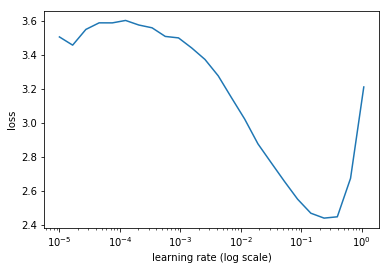

In [177]:
learn.sched.plot(0, 1)

In [184]:
lr = 2e-2

In [190]:
learn.fit(lr, 1, cycle_len=1)

A Jupyter Widget

 19%|█▉        | 6/32 [00:04<00:18,  1.41it/s, loss=2.3] 


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.27349    0.63054    0.801082  



[0.63054049, 0.80108173191547394]

In [191]:
learn

Sequential (
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU (inplace)
  (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, 

In [201]:
learn.freeze_to(-2)
lrs = np.array([lr / 1000, lr / 100, lr])

In [202]:
lrf = learn.lr_find(lrs/1000)

A Jupyter Widget

 84%|████████▍ | 27/32 [00:20<00:03,  1.35it/s, loss=4.11] 

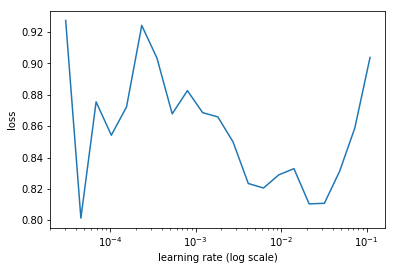

In [204]:
learn.sched.plot(1)

In [205]:
lrs/5

array([ 0.     ,  0.00004,  0.004  ])

In [206]:
learn.fit(lrs/5, 1, cycle_len=1)

A Jupyter Widget

 28%|██▊       | 9/32 [00:08<00:20,  1.12it/s, loss=0.78] 

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.750241   0.592268   0.821965  



[0.59226769, 0.82196514308452606]

In [207]:
learn.unfreeze()

In [208]:
learn.fit(lrs/5, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.610491   0.590518   0.82497   
    1      0.429081   0.544592   0.819111                  



[0.54459161, 0.81911057978868484]

In [209]:
learn.save('pasc_class_lrg')

In [212]:
preds = learn.predict_array(x); preds.shape

(64, 20)

In [220]:
pred_cats = np.argmax(np.exp(preds), 1)

diningtable diningtable


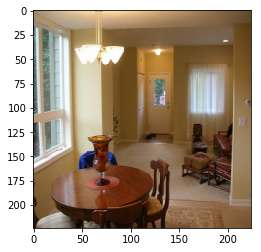

In [229]:
idx = 7
plt.imshow(data.val_ds.denorm(x.cpu().numpy())[idx])
print(data.classes[y[idx]], data.classes[pred_cats[idx]])

## BB only

### As above prepare csv

In [230]:
train_bb_lrg = {i: v[0] for i,v in train_annos_lrg.items()}

In [239]:
df = pd.DataFrame(
    {'fns': [train_fns[cont_idxs[i]] for i in range(len(cont_idxs))],
     'bbs': [' '.join([str(i) for i in train_bb_lrg[cont_idxs[i]]]) for i in range(len(cont_idxs))],
     },
    columns=['fns', 'bbs']
)

In [241]:
df.head()

,fns,bbs
0,000012.jpg,96 155 270 351
1,000017.jpg,77 89 336 403
2,000023.jpg,1 2 462 243
3,000026.jpg,124 89 212 337
4,000032.jpg,77 103 183 375


In [242]:
csv_path2 = './data/pascal/lrg_bb.csv'
df.to_csv(csv_path2, index=False)

### Set up regression problem

In [328]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)  # This last shit is important!!!

In [329]:
data2 = ImageClassifierData.from_csv(PATH, 'VOC2007/JPEGImages/', csv_path2, tfms=tfms, continuous=True)

In [330]:
x, y = next(iter(data2.val_dl))

In [331]:
y.size()

torch.Size([64, 4])

In [332]:
ima=data2.val_ds.denorm(to_np(x))[0]
b = np2cov(to_np(y[0])); b

[49.0, 0.0, 132.0, 206.0]

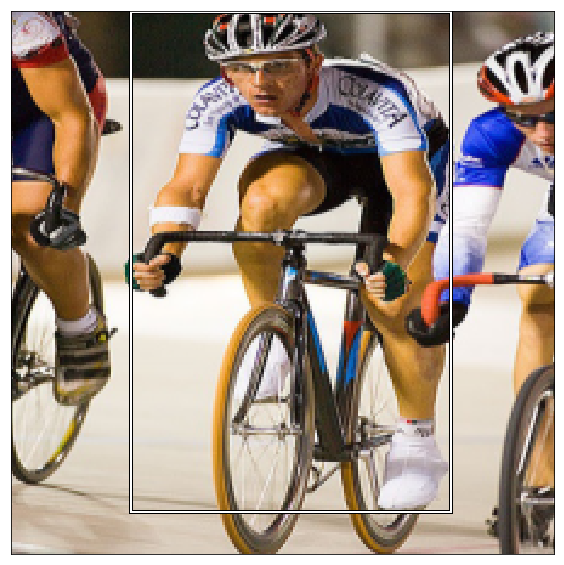

In [333]:
ax = show_img(ima)
draw_rect(ax, b)

In [334]:
512*7*7

25088

In [335]:
head = nn.Sequential(Flatten(), nn.Linear(512*7*7, 4))

In [336]:
learn2 = ConvLearner.pretrained(f_model, data2, custom_head=head)

In [337]:
learn2.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [338]:
learn2.opt_fn = optim.Adam

In [339]:
learn2.crit

<function torch.nn.functional.l1_loss>

In [340]:
lrf = learn2.lr_find(1e-5, 100)

A Jupyter Widget

 78%|███████▊  | 25/32 [00:11<00:03,  2.14it/s, loss=475] 

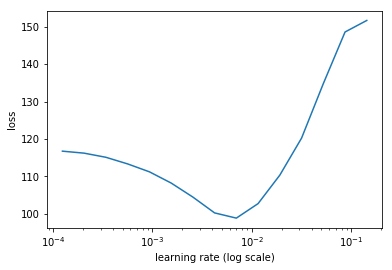

In [341]:
learn2.sched.plot(5)

In [342]:
lr = 2e-3

In [343]:
learn2.fit(lr, 2, cycle_len=1, cycle_mult=2) 

A Jupyter Widget

 47%|████▋     | 15/32 [00:07<00:08,  1.91it/s, loss=69.1]


Exception in thread Thread-59:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      49.224677  34.552052 
    1      37.92233   28.736191                           
    2      31.508765  27.686932                           



[27.686932]

In [285]:
learn2.freeze_to(-2)

In [286]:
lrs = np.array([lr / 1000, lr / 100, lr])

In [287]:
learn2.lr_find(lrs/1000)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      178.890237 1.03652546262e+15



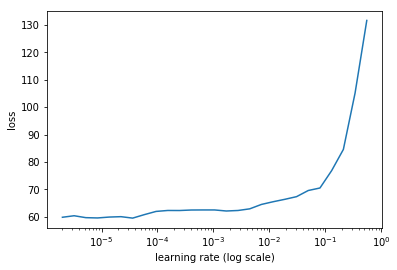

In [289]:
learn2.sched.plot(0)

In [264]:
learn2.fit(lrs/100, 1)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      88.005519  65.436508 



[65.436508]

In [266]:
learn2.fit(lrs/100, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      73.303094  64.477142 
    1      71.271058  61.742352                           



[61.742352]

In [267]:
learn2.unfreeze()
learn2.lr_find(lrs/1000)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      207.398112 2.18392850709e+17



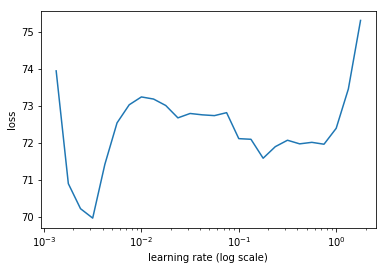

In [268]:
learn2.sched.plot(1)

In [269]:
learn2.fit(lrs/1000, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      70.62107   63.770859 
    1      71.271281  62.899658                           



[62.899658]